## Minnie Data Connectome Graph Analysis 

06/09/22 Full Connectome Data Extraction and Analysis

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import numpy as np

In [2]:
df = pd.read_pickle("neurons_synapse_target_for_filtered_updated_neuron_only_table_after_proofreading_with_metadata_060922_65029_neurons_stitched_with_pcm.pkl")
df = df.drop(['timestamp','id','classification_system','valid','cell_type','pt_supervoxel_id','cell_type_to_use','acceptable_out_degree','acceptable_in_degree','acceptable_out_connections_neighbors','acceptable_in_connections_neighbors','acceptable_out_synperconn','acceptable_in_synperconn'], axis = 1)
list_of_neurons = np.unique(df['pt_root_id'].to_numpy())

In [32]:
def extract_neighbors(seg_id):
    pre_syn_target_ids = df.loc[df['pt_root_id'] == seg_id, 'pre_syn_target_ids'].to_numpy()[0]
    seg_id_repeated = [seg_id] * len(pre_syn_target_ids)
    edge_table_1 = pd.DataFrame(
    {'Source': pre_syn_target_ids,
     'Target': seg_id_repeated,
    })
    post_syn_target_ids = df.loc[df['pt_root_id'] == seg_id, 'post_syn_target_ids'].to_numpy()[0]
    seg_id_repeated_2 = [seg_id] * len(post_syn_target_ids)
    edge_table_2 = pd.DataFrame(
    {'Source': seg_id_repeated_2,
     'Target': post_syn_target_ids,
    })
    synapse_edge_df = pd.concat([edge_table_1,edge_table_2])
    return synapse_edge_df

## BY LAYER SUBGRAPH ANALYSIS JUNE DATA

In [3]:
# Extract final node and edge tables below

nodes = pd.read_csv('FINAL_node2vec_results/final_connectome_node_table.csv')
edges = pd.read_csv('FINAL_node2vec_results/final_connectome_edge_table (1).csv')

In [4]:
def filter_by_layer(nodes, edges, layer):
    '''
    Extract subgraphs from June connectome data by layer for analysis
    Parameters: 
        nodes (Pandas dataframe) final june node dataframe
        edges (Pandas dataframe) final june edge dataframe 
        layer (string) layer of interest to extract
    Return: 
        node table subgraph (Pandas dataframe) by layer
        edge table subgraph (Pandas dataframe) by layer
        Subgraph G (NetworkX graph object)
    '''

    # Filter entire node table to only those in layer 
    rslt_synapse_df = nodes[nodes['layer'] == layer] 
    
    # Get list of unique neurons
    list_of_neurons = set(rslt_synapse_df['pt_root_id'].to_list())

    # Filter the synapse tables  extract all unique connections between nodes
    filtered = edges[edges['Source'].isin(list_of_neurons)]
    filtered2 = filtered[filtered['Target'].isin(list_of_neurons)]

    # create graph object
    G = nx.from_pandas_edgelist(filtered2, source="Source", target="Target", create_using=nx.DiGraph, edge_attr=["Euclidean_Distance"])
    list_of_current_nodes = set(list(G.nodes))
    missing_nodes = list(list_of_current_nodes ^ list_of_neurons)
    G.add_nodes_from(missing_nodes)
    
    return rslt_synapse_df, filtered2, G

In [5]:
node_L1, bedge_L1, G_L1 = filter_by_layer(nodes, edges, 'L1')  # sample run for subgraph L1
node_L23, bedge_L23, G_L23 = filter_by_layer(nodes, edges, 'L23')  # sample run for subgraph L23
node_L4, bedge_L4, G_L4 = filter_by_layer(nodes, edges, 'L4')  # sample run for subgraph L4
node_L5, bedge_L5, G_L5 = filter_by_layer(nodes, edges, 'L5')  # sample run for subgraph L5
node_L6, bedge_L6, G_6 = filter_by_layer(nodes, edges, 'L6')  # sample run for subgraph L6
node_LWM, bedge_LWM, G_LWM = filter_by_layer(nodes, edges, 'WM')  # sample run for subgraph LWM

## Layer Subgraph Metrics Analysis

In [6]:
print(G_L1,G_L23,G_L4,G_L5,G_6,G_LWM)

DiGraph with 1288 nodes and 10119 edges DiGraph with 14049 nodes and 767863 edges DiGraph with 17339 nodes and 1194054 edges DiGraph with 13439 nodes and 1212430 edges DiGraph with 18626 nodes and 1023028 edges DiGraph with 180 nodes and 454 edges


In [54]:
def degree_distribution(G, name, bins):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    plt.hist(degree_sequence, bins = bins)
    plt.title('Degree Distribution for Subgraph ' + name)
    plt.xlabel('Degree')
    plt.ylabel('count')

    return None

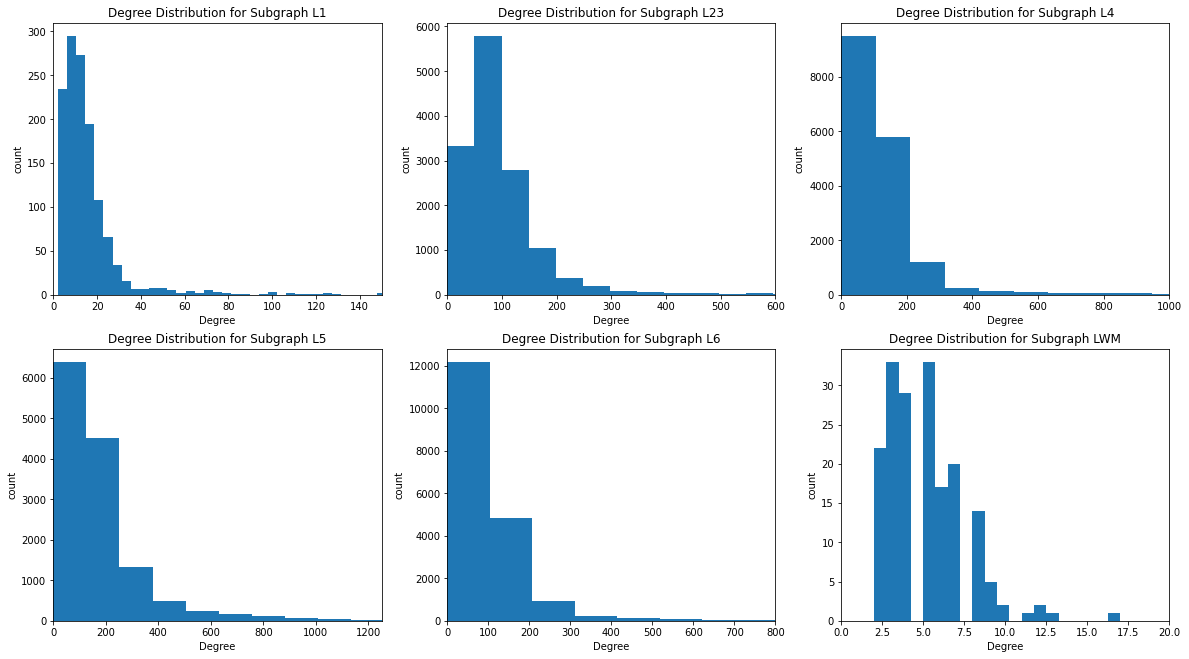

In [59]:
fig_1 = plt.figure(figsize = (20,11), facecolor='w',edgecolor='k')

plt.subplot(231)
degree_distribution(G_L1, "L1", bins = 40)
plt.xlim([0, 150])

plt.subplot(232)
degree_distribution(G_L23, "L23", bins = 45)
plt.xlim([0, 600])

plt.subplot(233)
degree_distribution(G_L4, "L4", bins = 45)
plt.xlim([0, 1000])

plt.subplot(234)
degree_distribution(G_L5, "L5", bins = 35)
plt.xlim([0, 1250])

plt.subplot(235)
degree_distribution(G_6, "L6", bins = 50)
plt.xlim([0, 800])

plt.subplot(236)
degree_distribution(G_LWM, "LWM", bins = 20)
plt.xlim([0, 20])

plt.show()

In [34]:
# compute the number of strongly connected components

subgraphs = [G_L1, G_L23, G_L4, G_L5, G_6, G_LWM]
number_of_cc_graphs = []

def num_of_connected_comp(G):
    undir_G = G.to_undirected(reciprocal = False)
    num = nx.number_connected_components(undir_G)
    return num


for i in range(6):
    number_of_cc_graphs.append(num_of_connected_comp(subgraphs[i]))

number_of_cc_graphs

[29, 55, 53, 51, 76, 26]

In [111]:
# compute the number of strongly connected components

subgraphs = [G_L1, G_L23, G_L4, G_L5, G_6, G_LWM]
density = []

def density_of_Graph(G):
    num = nx.density(G)
    return num

for i in range(6):
    density.append(density_of_Graph(subgraphs[i]))

density

[0.006104402843533278,
 0.0038906649294991125,
 0.0039719239324345484,
 0.006713594141336886,
 0.0029489787314693973,
 0.014090626939788952]

In [59]:
transitivity_lst = []

def transitivity(G):
    num = nx.transitivity(G)
    return num

for i in range(6):
    transitivity_lst.append(transitivity(subgraphs[i]))

In [60]:
transitivity_lst

[0.14571342017570432,
 0.1622668705299274,
 0.16198385509851995,
 0.13891511193945982,
 0.0835445989845833,
 0.09148936170212765]

In [61]:
num_of_cliques = []

def cliques(G):
    undir_G = G.to_undirected(reciprocal = False)
    num = nx.graph_number_of_cliques(undir_G)
    return num

for i in range(6):
    num_of_cliques.append(cliques(subgraphs[i]))

num_of_cliques

[5990, 6560270, 29400697, 57795721, 4078822, 219]

In [33]:
# Determine euclidean thickness of each cortical layer

import os
import json 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


DATA_DIR = os.path.join(os.getcwd())
f = open(os.path.join(DATA_DIR, 'smooth_minnie65_full_prediction.json'))
data = json.load(f)
cols_nm = np.array(data['cols_nm'])
bounds_nm = np.array(data['bounds'])*(10**6)

# Define the features x and z
x1 = cols_nm[:,0,0]
x2 = cols_nm[:,0,2]
x_lab = np.array([x1,x2]).T

In [26]:
bounds_nm = np.array(data['bounds'])*(10**6)
layer_bounds = bounds_nm.T
mean0 = np.mean(layer_bounds[0])
mean1 = np.mean(layer_bounds[1])
mean2 = np.mean(layer_bounds[2])
mean3 = np.mean(layer_bounds[3])
mean4 = np.mean(layer_bounds[4])


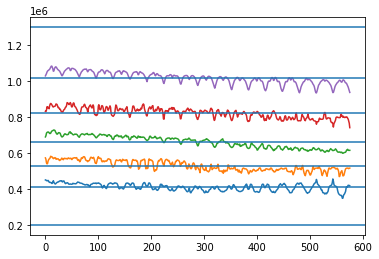

In [38]:
plt.plot(layer_bounds[0])
plt.plot(layer_bounds[1])
plt.plot(layer_bounds[2])
plt.plot(layer_bounds[3])
plt.plot(layer_bounds[4])
plt.axhline(y=mean0)
plt.axhline(y=mean1)
plt.axhline(y=mean2)
plt.axhline(y=mean3)
plt.axhline(y=mean4)
plt.axhline(y=1300000)
plt.axhline(y=200000)

In [34]:
def layer_volume(lower,upper):
    '''
    Calculate approximate volume of each layer given abs upper and lower bound
    '''
    upper_mm = upper / 1000000
    lower_mm = lower / 1000000
    height = upper_mm - lower_mm
    Cross_sectional_area = 0.87 * 0.84
    vol = height * Cross_sectional_area
    return vol

In [147]:
L1_volume = layer_volume(200000,mean0)
L23_volume = layer_volume(mean0,mean1)
L4_volume = layer_volume(mean1,mean2)
L5_volume = layer_volume(mean2,mean3)
L6_volume = layer_volume(mean3,mean4)
LWM_volume = layer_volume(mean4,1300000)

In [72]:
avg_closeness_cent = []

def avg_closeness_centrality(G):
    closeness_dict = nx.closeness_centrality(G)
    res = 0
    for val in closeness_dict.values():
        res += val
  
    # get total keys for mean computation
    res = res / len(closeness_dict)
    
    return res

for i in range(6):
    avg_closeness_cent.append(avg_closeness_centrality(subgraphs[i]))

avg_closeness_cent

[0.14802880308683716,
 0.2865180860432726,
 0.3040359626631406,
 0.3242011184017884,
 0.30553865653177026,
 0.03251228790758183]

In [130]:
# Extract nodes from each layer with high pagerank and eigenvector centrality and study its attribute patterns

from collections import OrderedDict

def Page_Rank(G):
    list_rank = nx.pagerank(G)
    sorted_values = np.argsort(list_rank.values())
    keys = list(list_rank.keys())

    sorted_dict = {keys[i]: sorted(
        list_rank.values())[i] for i in range(len(keys))}

    # extract top 10% of highest eignevector centrality values
    size = int(0.1 * len(sorted_dict))
    sorted_list = list(sorted_dict.keys())[-size:]
    return sorted_list

def eigenvector_cent(G):
    dict = nx.eigenvector_centrality_numpy(G)
    sorted_values = np.argsort(dict.values())
    keys = list(dict.keys())
     
    sorted_dict = {keys[i]: sorted(
        dict.values())[i] for i in range(len(keys))}

    # extract top 10% of highest eignevector centrality values
    size = int(0.1 * len(sorted_dict))
    sorted_list = list(sorted_dict.keys())[-size:]
    return sorted_list

In [138]:
def filter_node_attribute(list_of_sig_nodes):
    # filter node dataframe by the list of 
    df_filtered = nodes[nodes['pt_root_id'].isin(list_of_sig_nodes)]

    fig_1 = plt.figure(figsize = (20,6), facecolor='w',edgecolor='k')

    plt.subplot(131)
    plt.hist(df_filtered['cell_polarity'].to_numpy(), bins = 6)
    plt.title('Distribution of Cell Polarity')
 
    plt.subplot(132)
    plt.hist(df_filtered['pre_syn_count'].to_numpy(), bins = 6)
    plt.title('Distribution of Pre-synapse Count')

    plt.subplot(133)
    plt.hist(df_filtered['post_syn_count'].to_numpy(), bins = 6)
    plt.title('Distribution of Post-synapse Count')

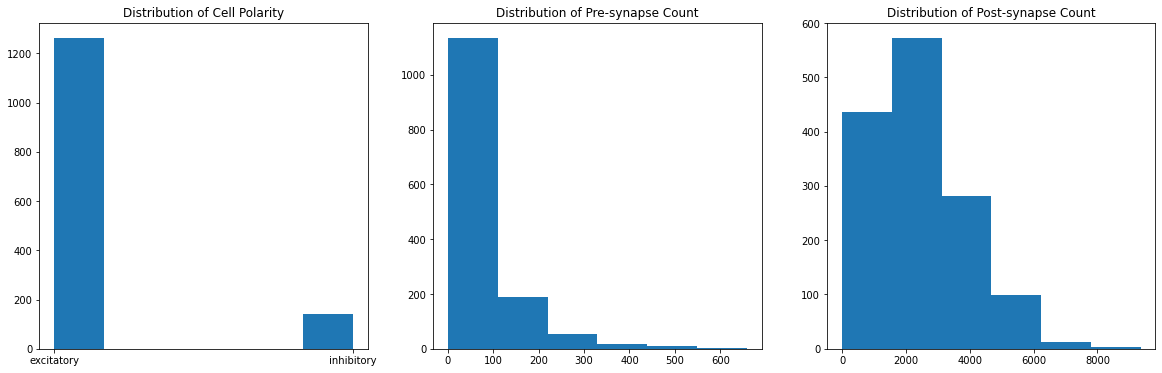

In [146]:
sig_nodes = eigenvector_cent(G_L23)
filter_node_attribute(sig_nodes)

### Compute Overall June Data Statistics

(0.0, 20000.0)

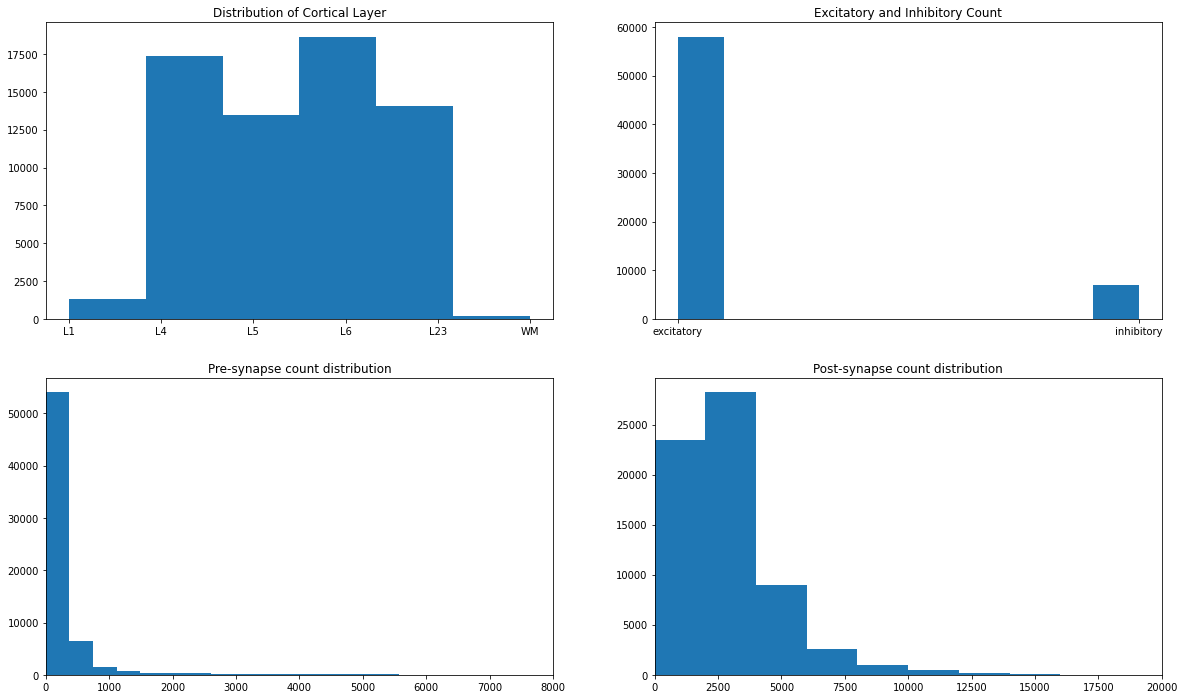

In [110]:
# node attributes distribution
fig_1 = plt.figure(figsize = (20,12), facecolor='w',edgecolor='k')

plt.subplot(221)
plt.hist(nodes['layer'].to_numpy(), bins = 6)
plt.title('Distribution of Cortical Layer')

plt.subplot(222)
plt.hist(nodes['cell_polarity'].to_numpy())
plt.title('Excitatory and Inhibitory Count')   

plt.subplot(223)
plt.hist(nodes['pre_syn_count'].to_numpy(), bins = 100)
plt.title('Pre-synapse count distribution')
plt.xlim([0,8000])

plt.subplot(224)
plt.hist(nodes['post_syn_count'].to_numpy(), bins = 100)
plt.title('Post-synapse count distribution')
plt.xlim([0,20000])

Text(0.5, 1.0, 'Distribution of Soma-Soma Euclidean Distance')

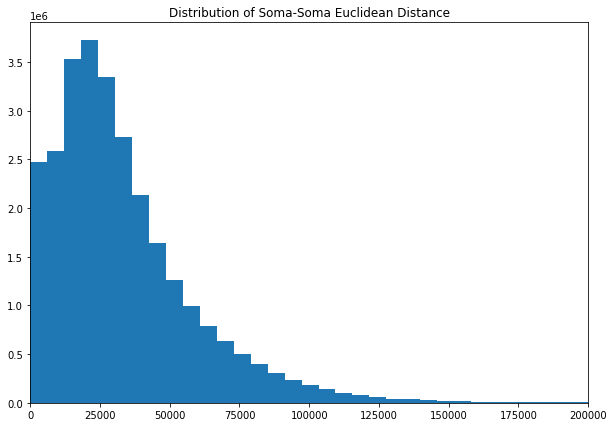

In [106]:
fig_1 = plt.figure(figsize = (10,7), facecolor='w',edgecolor='k')

plt.hist(edges['Euclidean_Distance'].to_numpy(), bins = 50)
plt.xlim([0,200000])
plt.title('Distribution of Soma-Soma Euclidean Distance')